In [1]:
import pyBigWig as pbw
import pandas as pd
from scipy import stats
import os
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from collections import OrderedDict
import matplotlib.backends.backend_pdf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import matplotlib.patches as patches
from glob import glob

In [2]:
primary_species = 'Arabidopsis_thaliana_Col-0'

# color_by_species = {
#     'Arabidopsis_thaliana_Col-0': '#e41a1c',
#     'Arabidopsis_lyrata_MN47': '#377eb8',
#     'Capsella_rubella_Monte_Gargano': '#4daf4a',
#     'Brassica_oleracea_TO1000DH3': '#984ea3'
# }

# species_order = [
#     'Arabidopsis_thaliana_Col-0',
#     'Arabidopsis_lyrata_MN47',
#     'Capsella_rubella_Monte_Gargano',
#     'Brassica_oleracea_TO1000DH3',
#     'Fragaria_vesca_Hawaii-4-F7',
#     'Populus_trichocarpa_Nisqually-1',
#     'Solanum_lycopersicum_Heinz-1706-BG',
#     'Solanum_tuberosum_DM_1-3-516-R44',
#     'Sorghum_bicolor_RTx430',
#     'Oryza_sativa_Nipponbare'
#     ]

species_order = [
    'Arabidopsis_thaliana_Col-0',
    'Arabidopsis_lyrata_MN47',
    'Capsella_rubella_Monte_Gargano',
    'Brassica_oleracea_TO1000DH3'
    ]

short_to_long_species_names = {}
long_to_short_species_names = {}

for long_name in species_order:
    genus, species, strain = long_name.split('_', maxsplit=2)
    short_name = genus[0] + '_' + species + '_' + strain
    short_to_long_species_names[short_name] = long_name
    long_to_short_species_names[long_name] = short_name


def gff_desc_to_dict(desc):
    desc_dict = {}
    for field in desc.split(';'):
        k, v = field.split('=', maxsplit=1)
        desc_dict[k] = v
            
    return desc_dict

def get_gene_name(feature_desc):
    name = gff_desc_to_dict(feature_desc).get('Name', 'no_name')
    if name.startswith('gene:Solyc'):
        name = name.split('.')[0].split(':')[1]

    return name

def parse_gff(filename):

    gff_cols = [
        'feature_chrom', 'feature_source', 'feature_type',
        'feature_start', 'feature_end', 'unused2',
        'feature_strand', 'feature_phase', 'feature_desc'
        ]

    gff_df = pd.read_csv(filename, sep='\t', names=gff_cols)
    gff_df = gff_df[gff_df['feature_type'] == 'gene']

    gff_df['gene_name'] = gff_df['feature_desc'].apply(get_gene_name)
    return gff_df



In [3]:

filtered_annotated_peaks_path = '/clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/raw_data/N4_filtered-annotated-peaks_minfoldch5_genebody_plus_500bpStart-to-plus-600bpStop_111924.tsv'
filtered_annotated_peaks = pd.read_csv(filtered_annotated_peaks_path, sep='\t')

In [4]:
# selected_species_long_names = [
#     'Arabidopsis_thaliana_Col-0',
#     'Arabidopsis_lyrata_MN47',
#     'Capsella_rubella_Monte_Gargano',
#     'Brassica_oleracea_TO1000DH3',
#     'Fragaria_vesca_Hawaii-4-F7',
#     'Populus_trichocarpa_Nisqually-1',
#     'Solanum_lycopersicum_Heinz-1706-BG',
#     'Solanum_tuberosum_DM_1-3-516-R44',
#     'Sorghum_bicolor_RTx430',
#     'Oryza_sativa_Nipponbare'
# ]

selected_species_long_names = [
    'Arabidopsis_thaliana_Col-0',
    'Arabidopsis_lyrata_MN47',
    'Capsella_rubella_Monte_Gargano',
    'Brassica_oleracea_TO1000DH3'
]

# library_allowlist = pd.read_csv('/clusterfs/jgi/groups/gentech/seqtech/plant_multidap_data/library_filtering/library_allowlist.tsv', sep='\t')

# selected_libraries = library_allowlist.copy()

# selected_libraries = selected_libraries[selected_libraries['athaliana_tf_id'].isin(tf_ids_to_plot)]
# selected_libraries = selected_libraries[selected_libraries['dataset_label'].isin(selected_dataset_labels)]
# selected_libraries = selected_libraries[selected_libraries['species'].isin(selected_species_long_names)]

# tf_ids_to_plot = selected_libraries['tf_id'].unique()

# display(selected_libraries)

In [5]:
expt_data_dirs = [
    '/clusterfs/jgi/groups/gentech/seqtech/plant_multidap_data/multiN4_new'
]

library_allowlist = pd.read_csv('/clusterfs/jgi/groups/gentech/seqtech/plant_multidap_data/library_filtering/library_allowlist_20241028.tsv', sep='\t')

# parse gffs for all species

gff_by_species = {}

for species_name in selected_species_long_names:
    gff_base_dir = '/clusterfs/jgi/groups/gentech/seqtech/plant_multidap_data/genomes/annotations'
    parsed_gff = parse_gff(os.path.join(gff_base_dir, species_name+'.gff'))
    gff_by_species[species_name] = parsed_gff

species_plot_order = [
    'Arabidopsis_thaliana_Col-0',
    'Arabidopsis_lyrata_MN47',
    'Capsella_rubella_Monte_Gargano',
    'Brassica_oleracea_TO1000DH3'
]

In [8]:
## 
#!awk '$27=="OG0015648" && $26=="Arabidopsis_thaliana_Col-0" && $37==4 && $29=="True"' /clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/raw_data/N4_filtered-annotated-peaks_minfoldch5_genebody_plus_500bpStart-to-plus-600bpStop_111924.tsv|less -S
selections_to_plot = [
    {   'orthogroup' : 'OG0015648', 
        'tfs': [
    'AT1G01060', #4
    'AT5G03790', #4
    'AT5G41570', #4
    'AT5G52020', #4
    'AT1G02250' #4
        ]   
    },
    {'orthogroup' : 'OG0015717', 
        'tfs': [
    'AT1G01060', #3
    'AT1G69780', #3
    'AT3G01970', #3
    'AT5G02320', #3
    'AT5G02840' #3
        ]   
    },
    {'orthogroup' : 'OG0016756', 
        'tfs': [
    'AT1G01060', #2
    'AT2G37590', #3
    'AT3G11280', #4
    'AT3G22830', #1
    'AT4G38000' #1
        ]   
    },
    {'orthogroup' : 'OG0011410', 
        'tfs': [
    'AT1G02250', #4
    'AT1G02230', #4
    'AT1G25340', #3
    'AT1G16490', #1
    'AT1G69570', #2
    'AT1G76420' #3
        ]   
    },
    {'orthogroup' : 'OG0011412', 
        'tfs': [
    'AT3G28920', #2
    'AT3G62420', #3
    'AT3G02940', #4
    'AT5G56110', #3
    'AT2G01940', #2
    'AT5G11260' #3
        ]   
    },
    {'orthogroup' : 'OG0011445', 
        'tfs': [
    'AT3G15500', #2
    'AT3G50260', #4
    'AT4G06746', #4
    'AT3G56400', #1
    'AT4G01500', #2
    'AT3G12730' #3
        ]   
    }
]


4
AT1G25530 AT1G25530.1 AT1G25530.1
Chr1
AT1G25530 AT1G25530.1 AT1G25530.1
Chr1
AT1G25530 AT1G25530.1 AT1G25530.1
Chr1
AT1G25530 AT1G25530.1 AT1G25530.1
Chr1
AL1G39770 AL1G39770.t1 AL1G39770.t1
scaffold_1
AL1G39770 AL1G39770.t1 AL1G39770.t1
scaffold_1
AL1G39770 AL1G39770.t1 AL1G39770.t1
scaffold_1
AL1G39770 AL1G39770.t1 AL1G39770.t1
scaffold_1
Carub.0001s2495 Carub.0001s2495.1 Carub.0001s2495.1
scaffold_1
Carub.0001s2495 Carub.0001s2495.1 Carub.0001s2495.1
scaffold_1
Carub.0001s2495 Carub.0001s2495.1 Carub.0001s2495.1
scaffold_1
Carub.0001s2495 Carub.0001s2495.1 Carub.0001s2495.1
scaffold_1
LOC106328770 LOC106328770 XP_013622733.1
NC_027750.1
LOC106328770 LOC106328770 XP_013622733.1
NC_027750.1
LOC106328770 LOC106328770 XP_013622733.1
NC_027750.1
LOC106328770 LOC106328770 XP_013622733.1
NC_027750.1


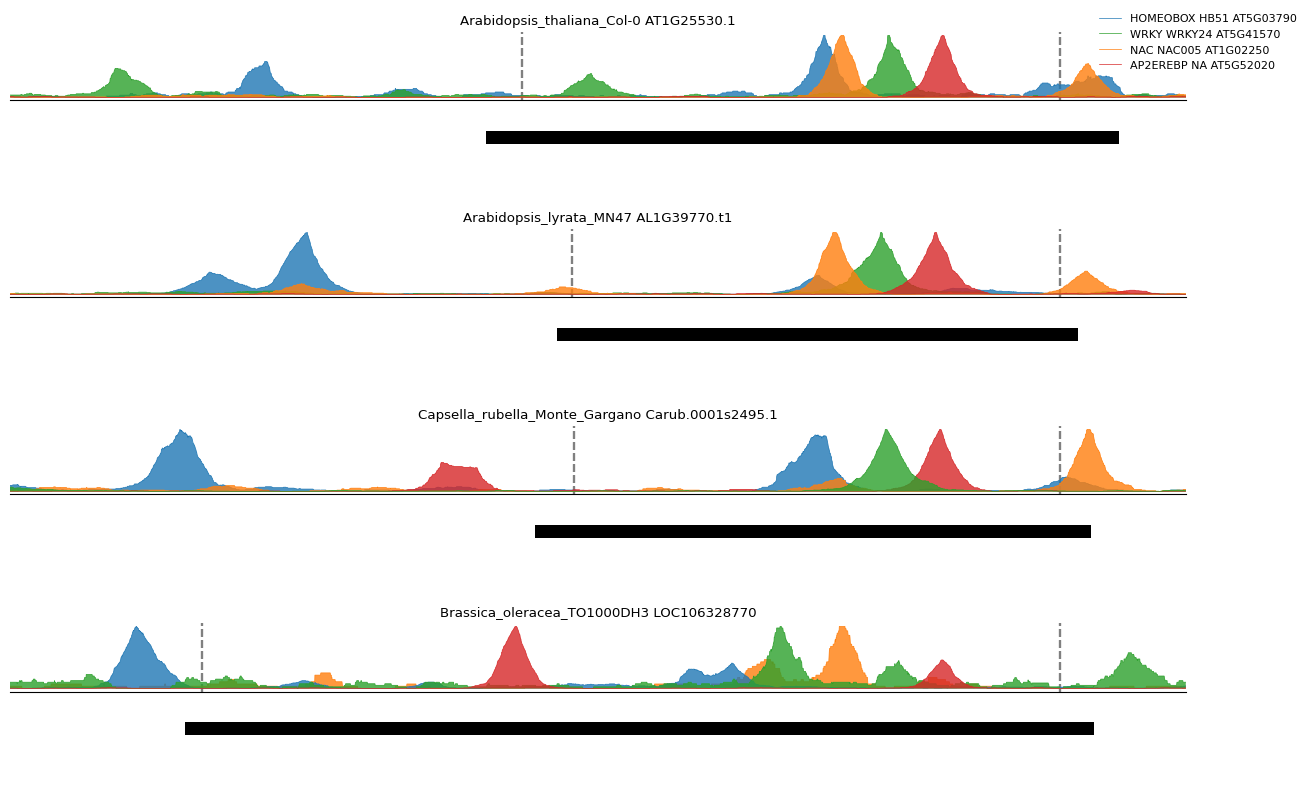

4
AT5G37180 AT5G37180.1 AT5G37180.1
Chr5
AT5G37180 AT5G37180.1 AT5G37180.1
Chr5
AT5G37180 AT5G37180.1 AT5G37180.1
Chr5
AT5G37180 AT5G37180.1 AT5G37180.1
Chr5
AT5G37180 AT5G37180.1 AT5G37180.1
Chr5
AL7G45720 AL7G45720.t1 AL7G45720.t1
scaffold_7
AL7G45720 AL7G45720.t1 AL7G45720.t1
scaffold_7
AL7G45720 AL7G45720.t1 AL7G45720.t1
scaffold_7
AL7G45720 AL7G45720.t1 AL7G45720.t1
scaffold_7
Carub.0007s3237 Carub.0007s3237.1 Carub.0007s3237.1
scaffold_7
Carub.0007s3237 Carub.0007s3237.1 Carub.0007s3237.1
scaffold_7
LOC106296231 LOC106296231 XP_013587766.1
NC_027753.1
LOC106296231 LOC106296231 XP_013587766.1
NC_027753.1
LOC106296231 LOC106296231 XP_013587766.1
NC_027753.1
LOC106296231 LOC106296231 XP_013587766.1
NC_027753.1


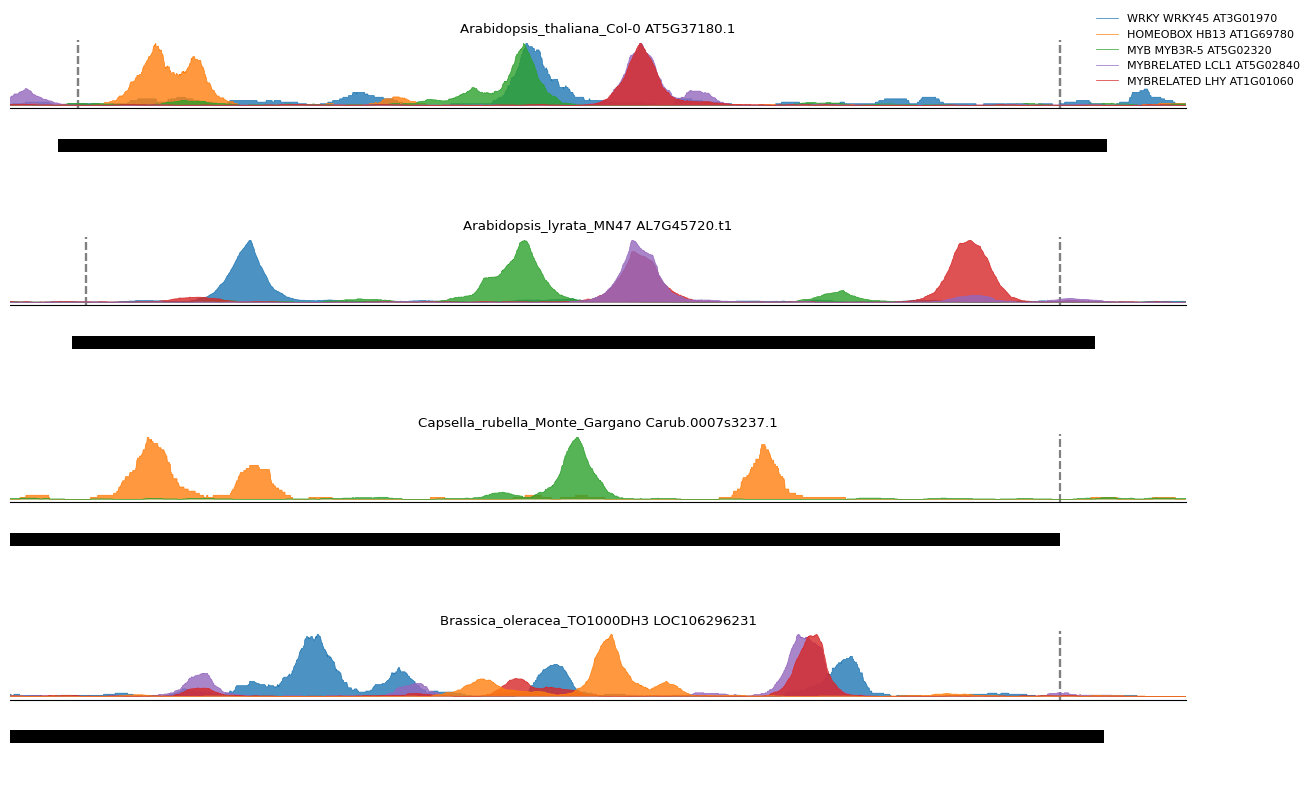

4
AT4G22960 AT4G22960.1 AT4G22960.1
Chr4
AT4G22960 AT4G22960.1 AT4G22960.1
Chr4
AT4G22960 AT4G22960.1 AT4G22960.1
Chr4
AT4G22960 AT4G22960.1 AT4G22960.1
Chr4
AT4G22960 AT4G22960.1 AT4G22960.1
Chr4
AL7G30560 AL7G30560.t1 AL7G30560.t1
scaffold_7
AL7G30560 AL7G30560.t1 AL7G30560.t1
scaffold_7
Carub.0007s1831 Carub.0007s1831.1 Carub.0007s1831.1
scaffold_7
LOC106326306 LOC106326306 XP_013619773.1
NC_027748.1
LOC106326306 LOC106326306 XP_013619773.1
NC_027748.1
LOC106326306 LOC106326306 XP_013619773.1
NC_027748.1


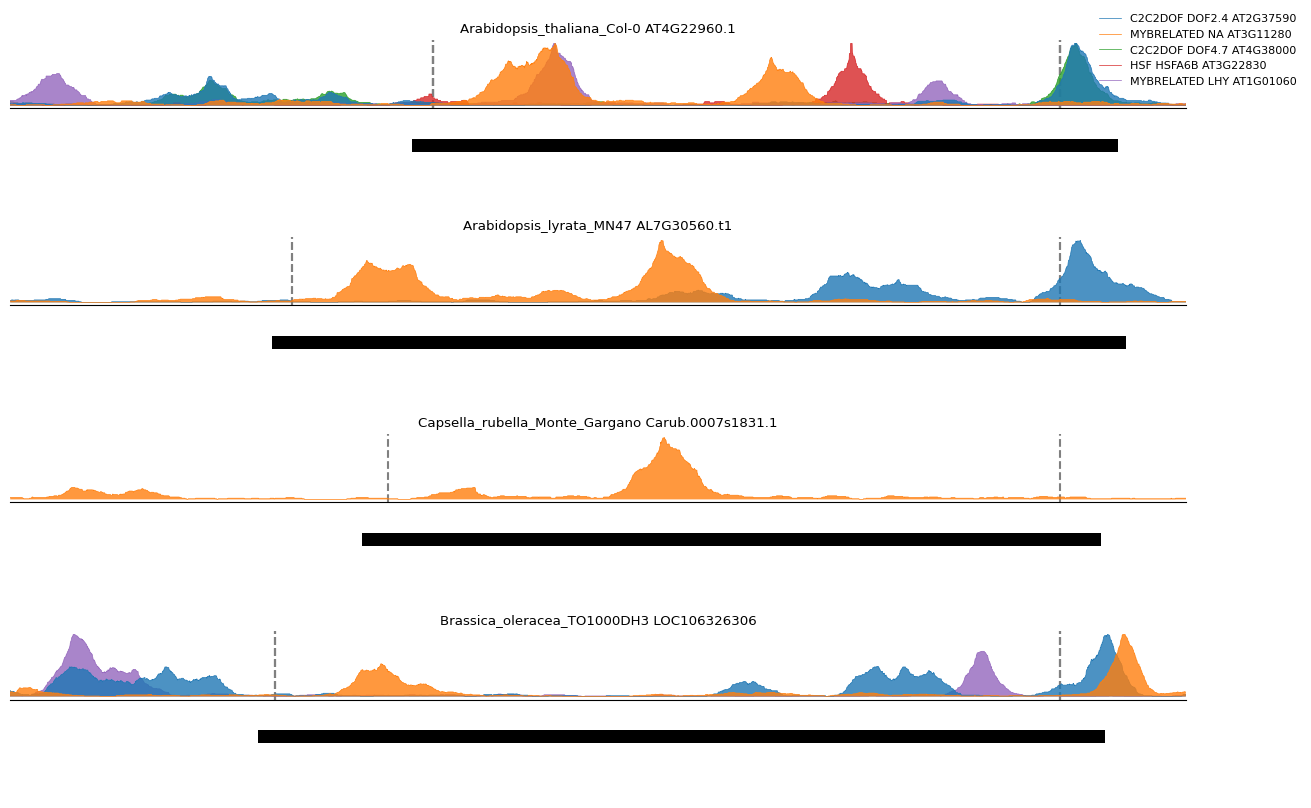

4
AT3G48380 AT3G48380.3 AT3G48380.3
Chr3
AT3G48380 AT3G48380.3 AT3G48380.3
Chr3
AT3G48380 AT3G48380.3 AT3G48380.3
Chr3
AT3G48380 AT3G48380.3 AT3G48380.3
Chr3
AT3G48380 AT3G48380.3 AT3G48380.3
Chr3
AT3G48380 AT3G48380.3 AT3G48380.3
Chr3
AL5G27780 AL5G27780.t1 AL5G27780.t1
scaffold_5
AL5G27780 AL5G27780.t1 AL5G27780.t1
scaffold_5
AL5G27780 AL5G27780.t1 AL5G27780.t1
scaffold_5
Carub.0005s1454 Carub.0005s1454.1 Carub.0005s1454.1
scaffold_5
Carub.0005s1454 Carub.0005s1454.1 Carub.0005s1454.1
scaffold_5
Carub.0005s1454 Carub.0005s1454.1 Carub.0005s1454.1
scaffold_5
Carub.0005s1454 Carub.0005s1454.1 Carub.0005s1454.1
scaffold_5
LOC106312271 LOC106312271 XP_013605180.1
NC_027755.1
LOC106312271 LOC106312271 XP_013605180.1
NC_027755.1
LOC106312271 LOC106312271 XP_013605180.1
NC_027755.1
LOC106312271 LOC106312271 XP_013605180.1
NC_027755.1


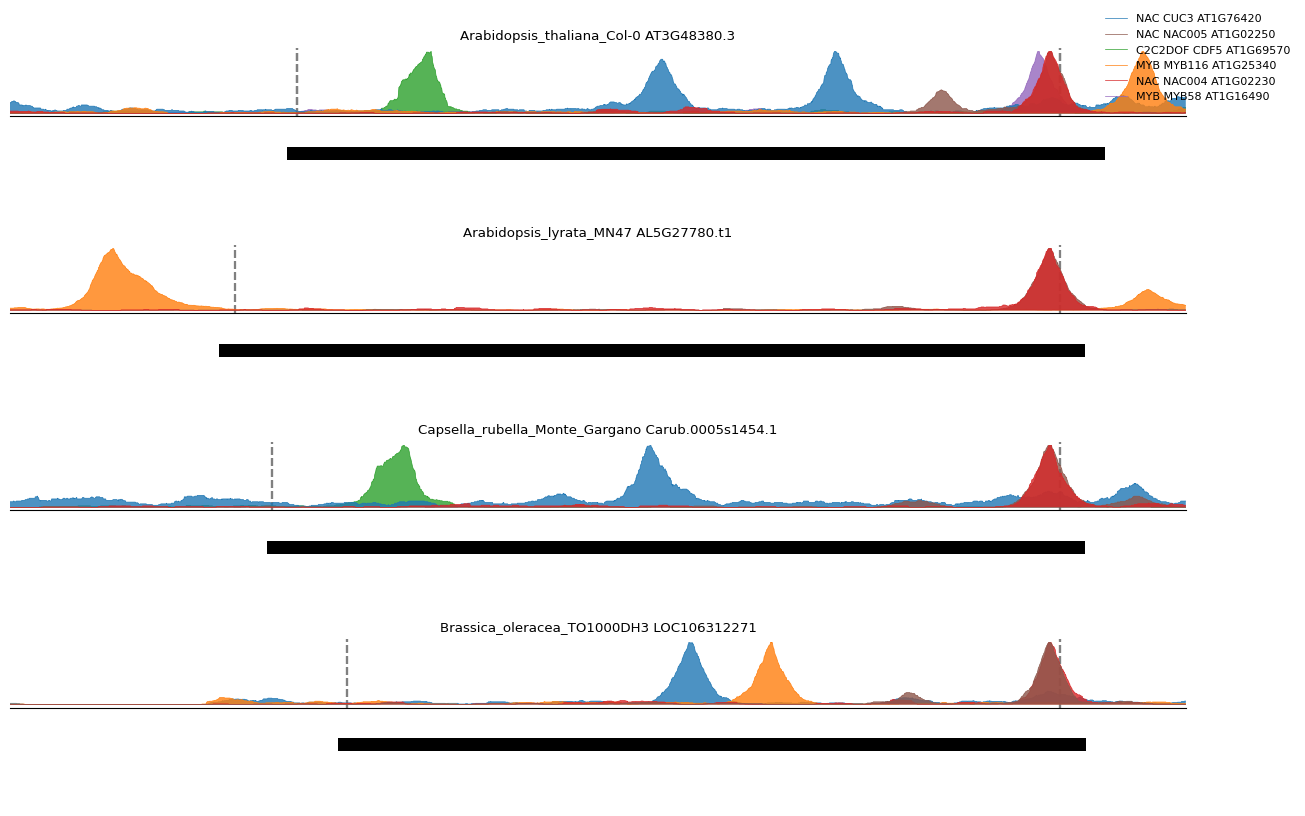

4
AT3G56270 AT3G56270.1 AT3G56270.1
Chr3
AT3G56270 AT3G56270.1 AT3G56270.1
Chr3
AT3G56270 AT3G56270.1 AT3G56270.1
Chr3
AT3G56270 AT3G56270.1 AT3G56270.1
Chr3
AT3G56270 AT3G56270.1 AT3G56270.1
Chr3
AL5G37590 AL5G37590.t1 AL5G37590.t1
scaffold_5
AL5G37590 AL5G37590.t1 AL5G37590.t1
scaffold_5
AL5G37590 AL5G37590.t1 AL5G37590.t1
scaffold_5
AL5G37590 AL5G37590.t1 AL5G37590.t1
scaffold_5
Carub.0005s2305 Carub.0005s2305.1 Carub.0005s2305.1
scaffold_5
Carub.0005s2305 Carub.0005s2305.1 Carub.0005s2305.1
scaffold_5
Carub.0005s2305 Carub.0005s2305.1 Carub.0005s2305.1
scaffold_5
Carub.0005s2305 Carub.0005s2305.1 Carub.0005s2305.1
scaffold_5
Carub.0005s2305 Carub.0005s2305.1 Carub.0005s2305.1
scaffold_5
LOC106310234 LOC106310234 XP_013602923.1
NC_027755.1


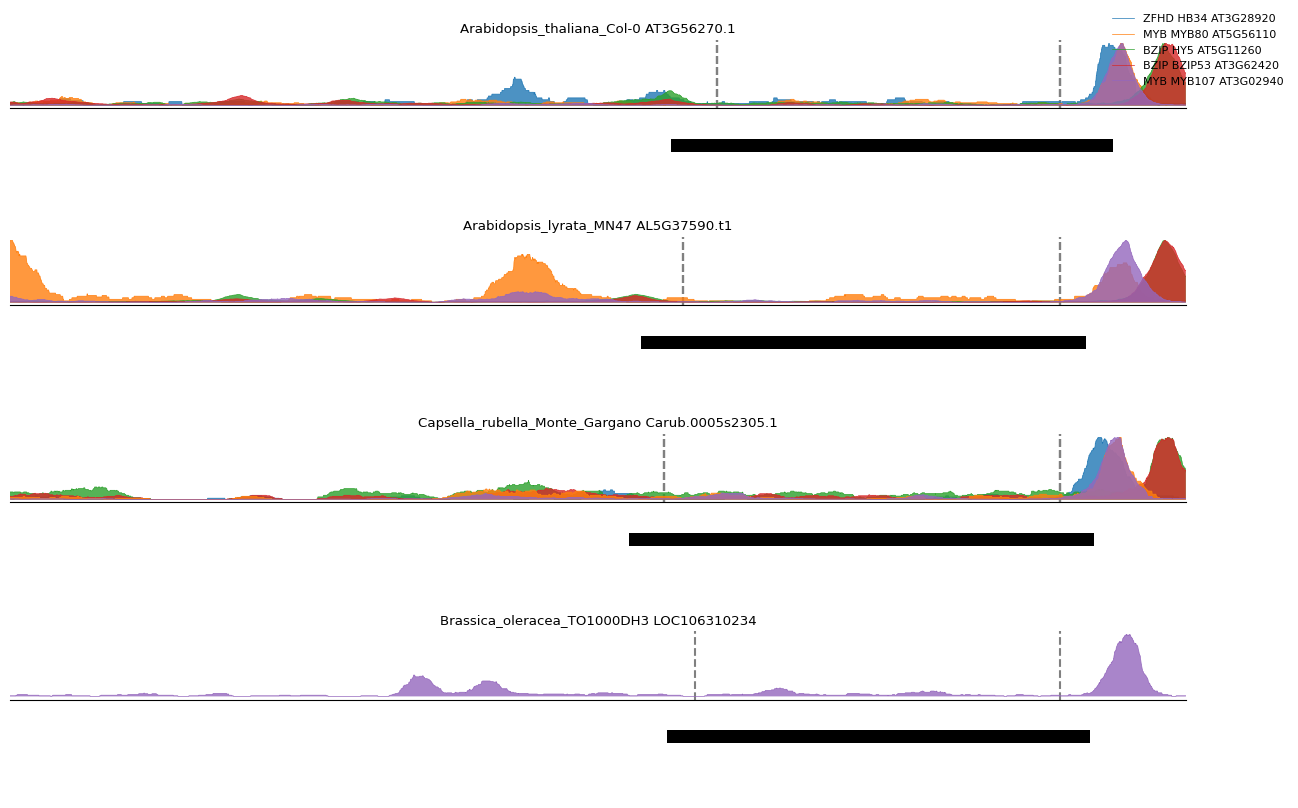

4
AT3G60240 AT3G60240.4 AT3G60240.4
Chr3
AT3G60240 AT3G60240.4 AT3G60240.4
Chr3
AT3G60240 AT3G60240.4 AT3G60240.4
Chr3
AT3G60240 AT3G60240.4 AT3G60240.4
Chr3
AT3G60240 AT3G60240.4 AT3G60240.4
Chr3
AT3G60240 AT3G60240.4 AT3G60240.4
Chr3
AL5G42450 AL5G42450.t2 AL5G42450.t2
scaffold_5
AL5G42450 AL5G42450.t2 AL5G42450.t2
scaffold_5
AL5G42450 AL5G42450.t2 AL5G42450.t2
scaffold_5
AL5G42450 AL5G42450.t2 AL5G42450.t2
scaffold_5
Carub.0005s2698 Carub.0005s2698.1 Carub.0005s2698.1
scaffold_5
Carub.0005s2698 Carub.0005s2698.1 Carub.0005s2698.1
scaffold_5
Carub.0005s2698 Carub.0005s2698.1 Carub.0005s2698.1
scaffold_5
LOC106341694 LOC106341694 XP_013635850.1
NC_027751.1
LOC106341694 LOC106341694 XP_013635850.1
NC_027751.1
LOC106341694 LOC106341694 XP_013635850.1
NC_027751.1


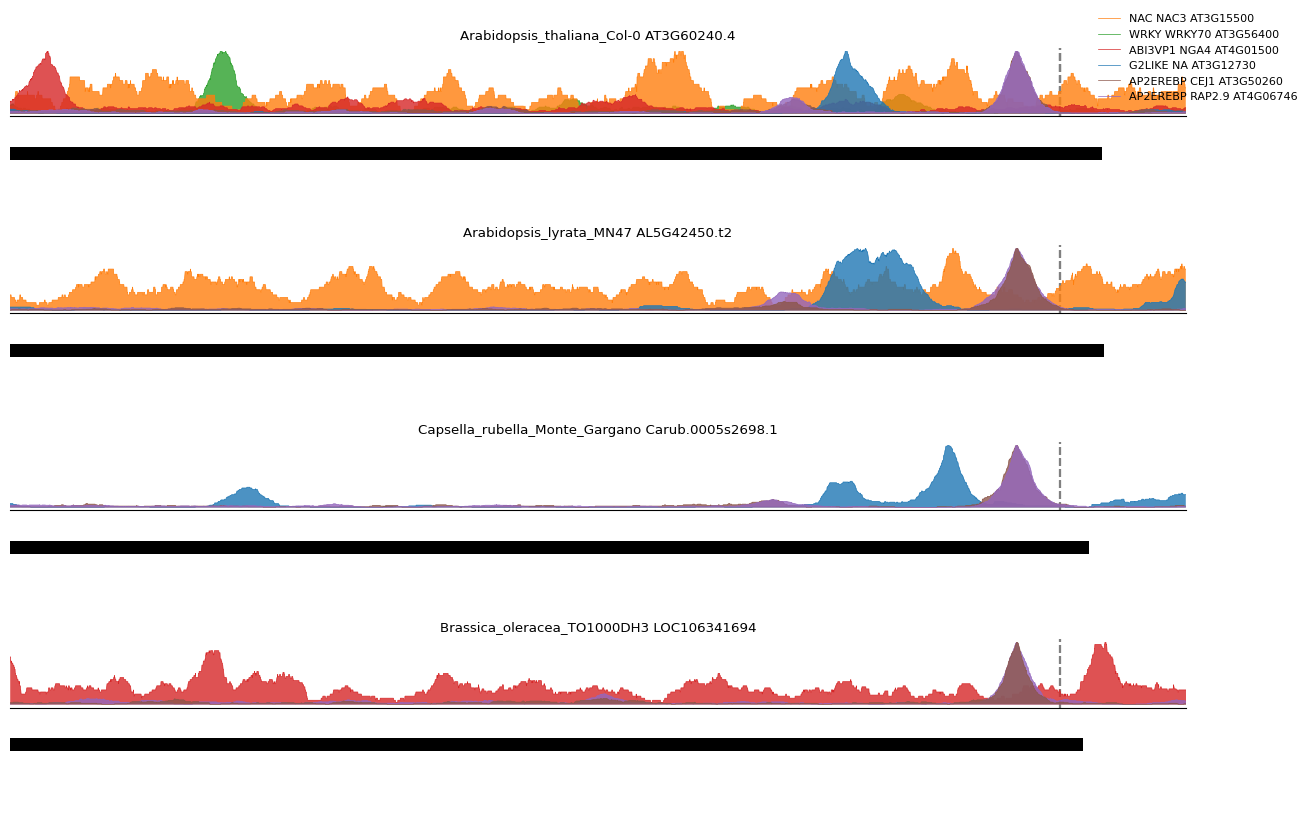

In [9]:
import matplotlib as mpl
from matplotlib import rcParams
# Set font properties globally
rcParams['pdf.fonttype'] = 42  # Ensures text is stored as editable text in PDF
rcParams['svg.fonttype'] = 'none'  # Ensures text is stored as editable text in SVG
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Arial']  # Use a font that is available on your system
plt.rcParams.update({'font.size': 8})


plt.rcParams.update({'font.size': 8})


def extract_bw_vals(bw_path, chrom, start, end):
    # print(bw_path)
    # print(chrom)
    # print(start)
    # print(end)
    bw = pbw.open(bw_path)
    bw_vals = bw.values(chrom, int(start), int(end))
    return bw_vals

def library_name_to_bw_path(library_name):
    data_path = '/clusterfs/jgi/groups/gentech/seqtech/plant_multidap_data/multiN4_new/*'
    bigwig_path = glob(os.path.join(data_path, library_name+'_dedup_norm.bw'))
    return bigwig_path[0]


for selection in selections_to_plot:
    
    orthogroup_to_plot = selection['orthogroup']
    tfs_to_plot = selection['tfs']

    selected_peaks = filtered_annotated_peaks.copy()
    selected_peaks = selected_peaks[selected_peaks['tf'].isin(tfs_to_plot)]
    selected_peaks = selected_peaks[selected_peaks['orthogroup'] == orthogroup_to_plot]

    selected_peaks = selected_peaks.sort_values(by='peak_foldch').drop_duplicates(subset=['tf', 'species', 'target_id'], keep='last')
    selected_peaks['library_name'] = selected_peaks['peak_name'].str.split('_peak_').str[0]

    selected_peaks = pd.merge(left=selected_peaks, right=library_allowlist, on='library_name', how='left')


    #Color by tf
    unique_tfs = selected_peaks['tf'].unique()
    palette = sns.color_palette("tab10", len(unique_tfs))
    color_mapping = {tf: color for tf, color in zip(unique_tfs, palette)}

    plot_counter = 0

    # color_order = [0,1,2,3,4]
    # pal = sns.color_palette('YlGnBu', len(color_order)+1)
    # color_order = [1,2,3,4]
    # pal = sns.color_palette('deep', len(color_order))
    #color_order = [4,3,2,1]
    #pal = ['#01273E','#700160','#FF3E31','#FBCE1D','#FFF180']

    for group_name, group in selected_peaks.groupby('orthogroup'):

        plot_suffix = group_name

        group = group.sort_values(by='species_x', key=lambda s: [species_order.index(x) for x in s.values])

        n_gene_targets = group['target_id'].nunique()
        target_id_plot_order = group.drop_duplicates(subset='target_id')['target_id'].to_list()
        print(n_gene_targets)
        #fig, axes = plt.subplots(nrows=n_gene_targets*2, ncols=1, figsize=(3,6))
        fig, axes = plt.subplots(nrows=n_gene_targets*2, ncols=1, figsize=(12, 8))

        ax_nums_where_genes_already_plotted = []
        
        for idx, row in group.iterrows():

            species = row['species_x']
            target_id = row['target_id']
            target_protein_id = row['protein_id']
            target_gene = row['gene']

            print(f'{target_gene} {target_id} {target_protein_id}')
            tf = row['tf']
            strand = row['feature_strand']
            chrom = row['feature_chr']

            print(chrom)
            cons_score = row['n_cons_species_minfrac0']

            tf_family = row['athaliana_tf_family']
            tf_name = row['athaliana_tf_name']
            if pd.isna(tf_name):
                tf_name = 'NA'
            tf_label =  f'{tf_family} {tf_name} {tf}'

            library_name = row['library_name']

            if strand == '+':
                plotting_start = row['feature_end'] + row['relative_cds_end'] - 5000
                plotting_end = row['feature_end'] + row['relative_cds_end'] + 600
                cds_end = row['feature_end'] + row['relative_cds_end']
                cds_start = row['feature_start'] + row['relative_cds_start']
            else:
                plotting_end = row['feature_start'] - row['relative_cds_end'] + 5000
                plotting_start = row['feature_start'] - row['relative_cds_end'] - 600
                cds_end = row['feature_start'] - row['relative_cds_end']
                cds_start = row['feature_end'] - row['relative_cds_start']

            # if strand == '+':
            #     plotting_start = row['feature_start'] + row['relative_cds_start'] + 500
            #     plotting_end = row['feature_end'] + row['relative_cds_end'] + 600
            #     cds_end = row['feature_end'] + row['relative_cds_end']
            # else:
            #     plotting_end = row['feature_end'] - row['relative_cds_start'] - 500
            #     plotting_start = row['feature_start'] - row['relative_cds_end'] - 600
            #     cds_end = row['feature_start'] - row['relative_cds_end']

            bw_path = library_name_to_bw_path(library_name)

            bw_vals = extract_bw_vals(bw_path, chrom, plotting_start, plotting_end)

            coverage_ax_num = target_id_plot_order.index(target_id)*2
            ax = axes[coverage_ax_num]

            autoscale_factor = max(bw_vals)
            y_vals = [y/autoscale_factor for y in bw_vals]
            x_vals = [x for x in range(plotting_start, plotting_end, 1)]

            #color = pal[color_order.index(cons_score)]
            color = color_mapping[tf]

            sns.lineplot(ax=ax, x=x_vals, y=y_vals, color=color, label=tf_label, legend=False, linewidth=0.5, alpha=1, zorder=cons_score)
            ax.fill_between(x=x_vals, y1=y_vals, y2=0, facecolor=color, zorder=cons_score, alpha=0.8)#, edgecolor=color, hatch=hatches_string)

            #if coverage_ax_num == 0:
            ax.axvline(cds_end, color='gray', linestyle='--', zorder=0)
            ax.axvline(cds_start, color='gray', linestyle='--', zorder=0)
                #if strand == '+':
                #    ax.axvline(cds_start+500, color='black', linestyle='--', zorder=0, alpha=0.3)
                #else:
                #    ax.axvline(cds_start-500, color='black', linestyle='--', zorder=0, alpha=0.3)

            ax.set_xlim(plotting_start, plotting_end)
            if strand == '-':
                ax.invert_xaxis()       

            ax.set_title(f'{species} {target_id}')

            gene_cartoon_ax_num = target_id_plot_order.index(target_id)*2+1
            gene_cartoon_ax = axes[gene_cartoon_ax_num]               

            if gene_cartoon_ax_num not in ax_nums_where_genes_already_plotted:

                genes_to_draw = gff_by_species[species]
                genes_to_draw = genes_to_draw[genes_to_draw['feature_chrom'] == chrom]
                genes_to_draw = genes_to_draw[genes_to_draw['feature_strand'] == strand]
                genes_to_draw = genes_to_draw[genes_to_draw['gene_name'] == target_gene]
                #genes_to_draw = genes_to_draw[genes_to_draw['feature_end'] >= plotting_start]
                #genes_to_draw = genes_to_draw[genes_to_draw['feature_start'] <= plotting_start]
                

                for idx, gene_row in genes_to_draw.iterrows():
                    gene_start = gene_row['feature_start']
                    gene_end = gene_row['feature_end']
                    gene_strand = gene_row['feature_strand']
                    # gene_name = gene_row['gene_name']

                    # Ensure the gene representation fits within the plotting range
                    rect_start = max(gene_start, plotting_start)
                    rect_end = min(gene_end, plotting_end)
                    rect_width = rect_end - rect_start

                    # Choose a color or pattern based on the gene strand
                    if strand == '+':
                        if gene_strand == '+':
                            rect_color = 'black'  # Example color for positive strand
                        else:
                            rect_color = 'gray'   # Example color for negative strand
                    else:
                        if gene_strand == '+':
                            rect_color = 'gray'  # Example color for positive strand
                        else:
                            rect_color = 'black'   # Example color for negative strand


                    # Draw the rectangle for the gene
                    rect_patch = patches.Rectangle(
                        (rect_start, 0.8),  # Lower-left corner (x, y)
                        rect_width,         # Width
                        0.2,                # Height
                        edgecolor='black',
                        facecolor=rect_color,
                        linewidth=0,
                        zorder=10
                    )
                    gene_cartoon_ax.add_patch(rect_patch)

                gene_cartoon_ax.set_xlim(plotting_start, plotting_end)
                gene_cartoon_ax.spines['bottom'].set_visible(False)

               # plot_bed_box(plt_box, chrom, plotting_start, plotting_end, gene_strand, species, axis=gene_cartoon_ax, cds_start=cds_start)

                ax_nums_where_genes_already_plotted.append(gene_cartoon_ax_num)

                if strand == '-':
                    gene_cartoon_ax.invert_xaxis()
                

        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

        handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
        handles, labels = [sum(x, []) for x in zip(*handles_labels)]
        by_label = OrderedDict(zip(labels, handles))
        fig.legend(by_label.values(), by_label.keys(), loc='center', bbox_to_anchor=(1, 0.95), frameon=False)
        # plt.tight_layout()
        plt.tight_layout()
        #plt.savefig(f'DAPpeaks-{plot_suffix}.svg', bbox_inches='tight')
        #plt.savefig(f'DAPpeaks-{plot_suffix}.svg')
        plt.savefig(f'DAPpeaks-{plot_suffix}.pdf')
        plt.show()




In [10]:
## 
#!awk '$27=="OG0015648" && $26=="Arabidopsis_thaliana_Col-0" && $37==4 && $29=="True"' /clusterfs/jgi/groups/gentech/homes/romalley/full_DAPseq_annotation/raw_data/N4_filtered-annotated-peaks_minfoldch5_genebody_plus_500bpStart-to-plus-600bpStop_111924.tsv|less -S
## for those orthogroup that are too long, 5000 is not enough to cover
selections_to_plot = [
    {'orthogroup' : 'OG0011445', 
        'tfs': [
    'AT3G15500', #2
    'AT3G50260', #4
    'AT4G06746', #4
    'AT3G56400', #1
    'AT4G01500', #2
    'AT3G12730' #3
        ]   
    }
]


4
AT3G60240 AT3G60240.4 AT3G60240.4
Chr3
AT3G60240 AT3G60240.4 AT3G60240.4
Chr3
AT3G60240 AT3G60240.4 AT3G60240.4
Chr3
AT3G60240 AT3G60240.4 AT3G60240.4
Chr3
AT3G60240 AT3G60240.4 AT3G60240.4
Chr3
AT3G60240 AT3G60240.4 AT3G60240.4
Chr3
AL5G42450 AL5G42450.t2 AL5G42450.t2
scaffold_5
AL5G42450 AL5G42450.t2 AL5G42450.t2
scaffold_5
AL5G42450 AL5G42450.t2 AL5G42450.t2
scaffold_5
AL5G42450 AL5G42450.t2 AL5G42450.t2
scaffold_5
Carub.0005s2698 Carub.0005s2698.1 Carub.0005s2698.1
scaffold_5
Carub.0005s2698 Carub.0005s2698.1 Carub.0005s2698.1
scaffold_5
Carub.0005s2698 Carub.0005s2698.1 Carub.0005s2698.1
scaffold_5
LOC106341694 LOC106341694 XP_013635850.1
NC_027751.1
LOC106341694 LOC106341694 XP_013635850.1
NC_027751.1
LOC106341694 LOC106341694 XP_013635850.1
NC_027751.1


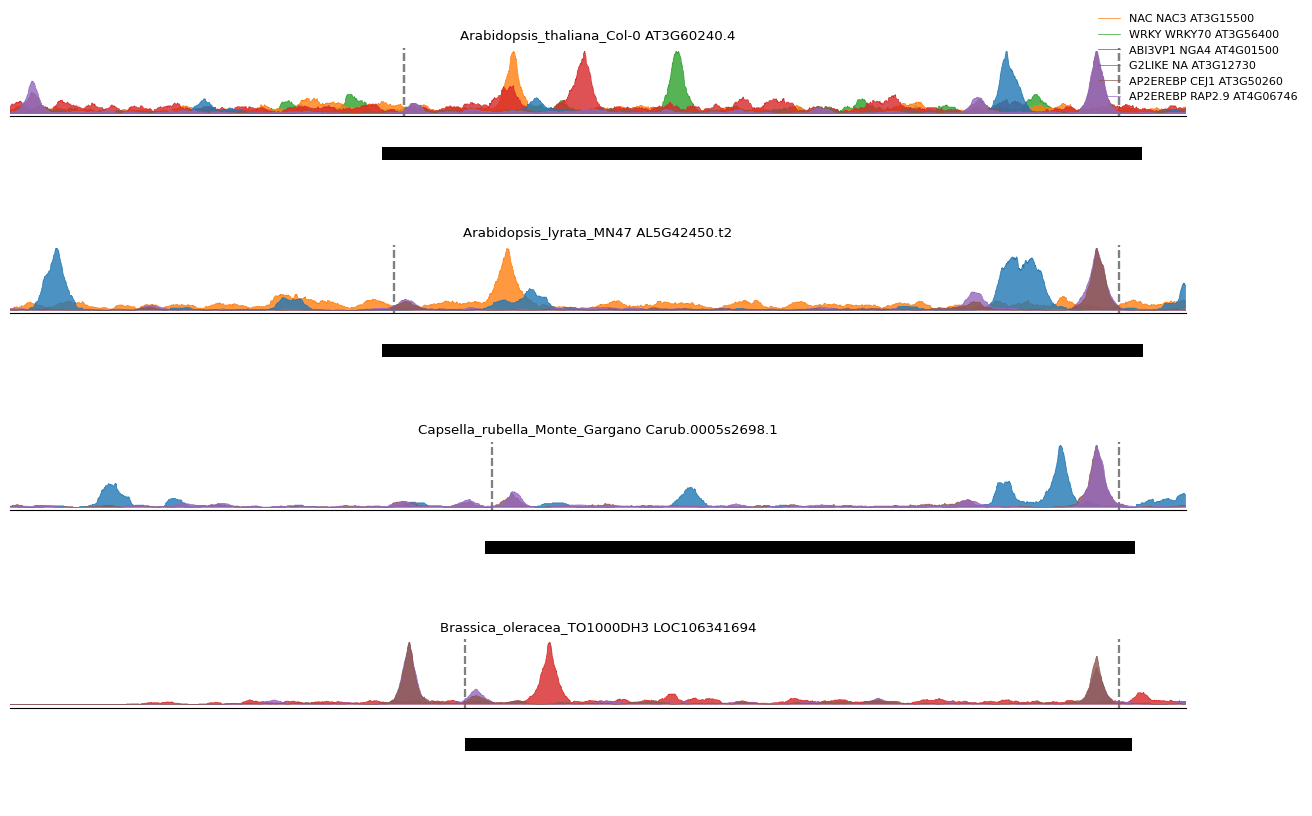

In [11]:
import matplotlib as mpl
from matplotlib import rcParams
# Set font properties globally
rcParams['pdf.fonttype'] = 42  # Ensures text is stored as editable text in PDF
rcParams['svg.fonttype'] = 'none'  # Ensures text is stored as editable text in SVG
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Arial']  # Use a font that is available on your system
plt.rcParams.update({'font.size': 8})



plt.rcParams.update({'font.size': 8})


def extract_bw_vals(bw_path, chrom, start, end):
    # print(bw_path)
    # print(chrom)
    # print(start)
    # print(end)
    bw = pbw.open(bw_path)
    bw_vals = bw.values(chrom, int(start), int(end))
    return bw_vals

def library_name_to_bw_path(library_name):
    data_path = '/clusterfs/jgi/groups/gentech/seqtech/plant_multidap_data/multiN4_new/*'
    bigwig_path = glob(os.path.join(data_path, library_name+'_dedup_norm.bw'))
    return bigwig_path[0]


for selection in selections_to_plot:
    
    orthogroup_to_plot = selection['orthogroup']
    tfs_to_plot = selection['tfs']

    selected_peaks = filtered_annotated_peaks.copy()
    selected_peaks = selected_peaks[selected_peaks['tf'].isin(tfs_to_plot)]
    selected_peaks = selected_peaks[selected_peaks['orthogroup'] == orthogroup_to_plot]

    selected_peaks = selected_peaks.sort_values(by='peak_foldch').drop_duplicates(subset=['tf', 'species', 'target_id'], keep='last')
    selected_peaks['library_name'] = selected_peaks['peak_name'].str.split('_peak_').str[0]

    selected_peaks = pd.merge(left=selected_peaks, right=library_allowlist, on='library_name', how='left')


    #Color by tf
    unique_tfs = selected_peaks['tf'].unique()
    palette = sns.color_palette("tab10", len(unique_tfs))
    color_mapping = {tf: color for tf, color in zip(unique_tfs, palette)}

    plot_counter = 0

    # color_order = [0,1,2,3,4]
    # pal = sns.color_palette('YlGnBu', len(color_order)+1)
    # color_order = [1,2,3,4]
    # pal = sns.color_palette('deep', len(color_order))
    #color_order = [4,3,2,1]
    #pal = ['#01273E','#700160','#FF3E31','#FBCE1D','#FFF180']

    for group_name, group in selected_peaks.groupby('orthogroup'):

        plot_suffix = group_name

        group = group.sort_values(by='species_x', key=lambda s: [species_order.index(x) for x in s.values])

        n_gene_targets = group['target_id'].nunique()
        target_id_plot_order = group.drop_duplicates(subset='target_id')['target_id'].to_list()
        print(n_gene_targets)
        #fig, axes = plt.subplots(nrows=n_gene_targets*2, ncols=1, figsize=(3,6))
        fig, axes = plt.subplots(nrows=n_gene_targets*2, ncols=1, figsize=(12, 8))

        ax_nums_where_genes_already_plotted = []
        
        for idx, row in group.iterrows():

            species = row['species_x']
            target_id = row['target_id']
            target_protein_id = row['protein_id']
            target_gene = row['gene']

            print(f'{target_gene} {target_id} {target_protein_id}')
            tf = row['tf']
            strand = row['feature_strand']
            chrom = row['feature_chr']

            print(chrom)
            cons_score = row['n_cons_species_minfrac0']

            tf_family = row['athaliana_tf_family']
            tf_name = row['athaliana_tf_name']
            if pd.isna(tf_name):
                tf_name = 'NA'
            tf_label =  f'{tf_family} {tf_name} {tf}'

            library_name = row['library_name']

            if strand == '+':
                plotting_start = row['feature_end'] + row['relative_cds_end'] - 10000
                plotting_end = row['feature_end'] + row['relative_cds_end'] + 600
                cds_end = row['feature_end'] + row['relative_cds_end']
                cds_start = row['feature_start'] + row['relative_cds_start']
            else:
                plotting_end = row['feature_start'] - row['relative_cds_end'] + 10000
                plotting_start = row['feature_start'] - row['relative_cds_end'] - 600
                cds_end = row['feature_start'] - row['relative_cds_end']
                cds_start = row['feature_end'] - row['relative_cds_start']

            bw_path = library_name_to_bw_path(library_name)

            bw_vals = extract_bw_vals(bw_path, chrom, plotting_start, plotting_end)

            coverage_ax_num = target_id_plot_order.index(target_id)*2
            ax = axes[coverage_ax_num]

            autoscale_factor = max(bw_vals)
            y_vals = [y/autoscale_factor for y in bw_vals]
            x_vals = [x for x in range(plotting_start, plotting_end, 1)]

            #color = pal[color_order.index(cons_score)]
            color = color_mapping[tf]

            sns.lineplot(ax=ax, x=x_vals, y=y_vals, color=color, label=tf_label, legend=False, linewidth=0.5, alpha=1, zorder=cons_score)
            ax.fill_between(x=x_vals, y1=y_vals, y2=0, facecolor=color, zorder=cons_score, alpha=0.8)#, edgecolor=color, hatch=hatches_string)

            #if coverage_ax_num == 0:
            ax.axvline(cds_end, color='gray', linestyle='--', zorder=0)
            ax.axvline(cds_start, color='gray', linestyle='--', zorder=0)
                #if strand == '+':
                #    ax.axvline(cds_start+500, color='black', linestyle='--', zorder=0, alpha=0.3)
                #else:
                #    ax.axvline(cds_start-500, color='black', linestyle='--', zorder=0, alpha=0.3)

            ax.set_xlim(plotting_start, plotting_end)
            if strand == '-':
                ax.invert_xaxis()       

            ax.set_title(f'{species} {target_id}')

            gene_cartoon_ax_num = target_id_plot_order.index(target_id)*2+1
            gene_cartoon_ax = axes[gene_cartoon_ax_num]               

            if gene_cartoon_ax_num not in ax_nums_where_genes_already_plotted:

                genes_to_draw = gff_by_species[species]
                genes_to_draw = genes_to_draw[genes_to_draw['feature_chrom'] == chrom]
                genes_to_draw = genes_to_draw[genes_to_draw['feature_strand'] == strand]
                genes_to_draw = genes_to_draw[genes_to_draw['gene_name'] == target_gene]
                #genes_to_draw = genes_to_draw[genes_to_draw['feature_end'] >= plotting_start]
                #genes_to_draw = genes_to_draw[genes_to_draw['feature_start'] <= plotting_start]
                

                for idx, gene_row in genes_to_draw.iterrows():
                    gene_start = gene_row['feature_start']
                    gene_end = gene_row['feature_end']
                    gene_strand = gene_row['feature_strand']
                    # gene_name = gene_row['gene_name']

                    # Ensure the gene representation fits within the plotting range
                    rect_start = max(gene_start, plotting_start)
                    rect_end = min(gene_end, plotting_end)
                    rect_width = rect_end - rect_start

                    # Choose a color or pattern based on the gene strand
                    if strand == '+':
                        if gene_strand == '+':
                            rect_color = 'black'  # Example color for positive strand
                        else:
                            rect_color = 'gray'   # Example color for negative strand
                    else:
                        if gene_strand == '+':
                            rect_color = 'gray'  # Example color for positive strand
                        else:
                            rect_color = 'black'   # Example color for negative strand


                    # Draw the rectangle for the gene
                    rect_patch = patches.Rectangle(
                        (rect_start, 0.8),  # Lower-left corner (x, y)
                        rect_width,         # Width
                        0.2,                # Height
                        edgecolor='black',
                        facecolor=rect_color,
                        linewidth=0,
                        zorder=10
                    )
                    gene_cartoon_ax.add_patch(rect_patch)

                gene_cartoon_ax.set_xlim(plotting_start, plotting_end)
                gene_cartoon_ax.spines['bottom'].set_visible(False)

               # plot_bed_box(plt_box, chrom, plotting_start, plotting_end, gene_strand, species, axis=gene_cartoon_ax, cds_start=cds_start)

                ax_nums_where_genes_already_plotted.append(gene_cartoon_ax_num)

                if strand == '-':
                    gene_cartoon_ax.invert_xaxis()
                

        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

        handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
        handles, labels = [sum(x, []) for x in zip(*handles_labels)]
        by_label = OrderedDict(zip(labels, handles))
        fig.legend(by_label.values(), by_label.keys(), loc='center', bbox_to_anchor=(1, 0.95), frameon=False)
        # plt.tight_layout()
        plt.tight_layout()
        #plt.savefig(f'DAPpeaks-{plot_suffix}.svg', bbox_inches='tight')
        #plt.savefig(f'DAPpeaks-{plot_suffix}.svg')
        plt.savefig(f'DAPpeaks-{plot_suffix}.pdf')
        plt.show()




## Make plots for distal peaks, especially for auxin genes

In [6]:

filtered_annotated_peaks_path = '/clusterfs/jgi/scratch/gentech/seqtech/amc/multidap_tables/N4_filtered-annotated-peaks_minfoldch5_minus10kb_to_minus2kb_031025.tsv'
filtered_annotated_peaks = pd.read_csv(filtered_annotated_peaks_path, sep='\t')

In [7]:
selected_species_long_names = [
    'Arabidopsis_thaliana_Col-0',
    'Arabidopsis_lyrata_MN47',
    'Capsella_rubella_Monte_Gargano',
    'Brassica_oleracea_TO1000DH3'
]

expt_data_dirs = [
    '/clusterfs/jgi/groups/gentech/seqtech/plant_multidap_data/multiN4_new'
]

library_allowlist = pd.read_csv('/clusterfs/jgi/groups/gentech/seqtech/plant_multidap_data/library_filtering/library_allowlist_20241028.tsv', sep='\t')

# parse gffs for all species

gff_by_species = {}

for species_name in selected_species_long_names:
    gff_base_dir = '/clusterfs/jgi/groups/gentech/seqtech/plant_multidap_data/genomes/annotations'
    parsed_gff = parse_gff(os.path.join(gff_base_dir, species_name+'.gff'))
    gff_by_species[species_name] = parsed_gff

species_plot_order = [
    'Arabidopsis_thaliana_Col-0',
    'Arabidopsis_lyrata_MN47',
    'Capsella_rubella_Monte_Gargano',
    'Brassica_oleracea_TO1000DH3'
]

In [8]:
#!awk '$27=="OG0018180" && $26=="Arabidopsis_thaliana_Col-0" && $29=="True"{print $31,$37}' /clusterfs/jgi/scratch/gentech/seqtech/amc/multidap_tables/N4_filtered-annotated-peaks_minfoldch5_minus10kb_to_minus2kb_031025.tsv|sort|uniq|less -S

In [9]:
## 
selections_to_plot = [
    {   'orthogroup' : 'OG0018180', ## auxin gene AT1G65920
        'tfs': [
    'AT1G18330', #4
    'AT1G20910', #4
    'AT1G19210', #4
    'AT3G01220', #4
    'AT3G09600' #4
        ]   
    },
    {'orthogroup' : 'OG0001467',  ##  auxin gene AT3G23050
        'tfs': [
    'AT1G01060', #4
    'AT1G02230', #4
    'AT1G06850', #4
    'AT1G18330', #4
    'AT1G22810' #4
        ]   
    },
    {'orthogroup' : 'OG0011588',  ## auxin gene AT3G28857
        'tfs': [
    'AT5G66940', #4
    'AT5G60850', #4
    'AT1G80840', #4
    'AT2G22430', #4
    'AT2G28810' #4
        ]   
    },
    {'orthogroup' : 'OG0005200', ## auxin gene AT4G31320
        'tfs': [
    'AT1G64620', #4
    'AT1G69780', #4
    'AT5G03790', #4
    'AT5G47390', #4
    'AT5G66700', #4
    'AT5G66940' #4
        ]   
    },
    {'orthogroup' : 'OG0008810', ## auxin gene AT1G19840
        'tfs': [
    'AT1G06850', #3
    'AT1G18330', #1
    'AT1G29160', #2
    'AT1G36060', #3
    'AT1G46768', #2
    'AT3G10113' #3
        ]   
    }
]


4
AT1G65920 AT1G65920.1 AT1G65920.1
Chr1
AT1G65920 AT1G65920.1 AT1G65920.1
Chr1
AT1G65920 AT1G65920.1 AT1G65920.1
Chr1
AT1G65920 AT1G65920.1 AT1G65920.1
Chr1
AT1G65920 AT1G65920.1 AT1G65920.1
Chr1
AL2G23300 AL2G23300.t1 AL2G23300.t1
scaffold_2
AL2G23300 AL2G23300.t1 AL2G23300.t1
scaffold_2
AL2G23300 AL2G23300.t1 AL2G23300.t1
scaffold_2
AL2G23300 AL2G23300.t1 AL2G23300.t1
scaffold_2
AL2G23300 AL2G23300.t1 AL2G23300.t1
scaffold_2
Carub.0002s1186 Carub.0002s1186.1 Carub.0002s1186.1
scaffold_2
Carub.0002s1186 Carub.0002s1186.1 Carub.0002s1186.1
scaffold_2
Carub.0002s1186 Carub.0002s1186.1 Carub.0002s1186.1
scaffold_2
Carub.0002s1186 Carub.0002s1186.1 Carub.0002s1186.1
scaffold_2
Carub.0002s1186 Carub.0002s1186.1 Carub.0002s1186.1
scaffold_2
LOC106335901 LOC106335901 XP_013630027.1
NC_027750.1
LOC106335901 LOC106335901 XP_013630027.1
NC_027750.1
LOC106335901 LOC106335901 XP_013630027.1
NC_027750.1
LOC106335901 LOC106335901 XP_013630027.1
NC_027750.1
LOC106335901 LOC106335901 XP_013630027.1


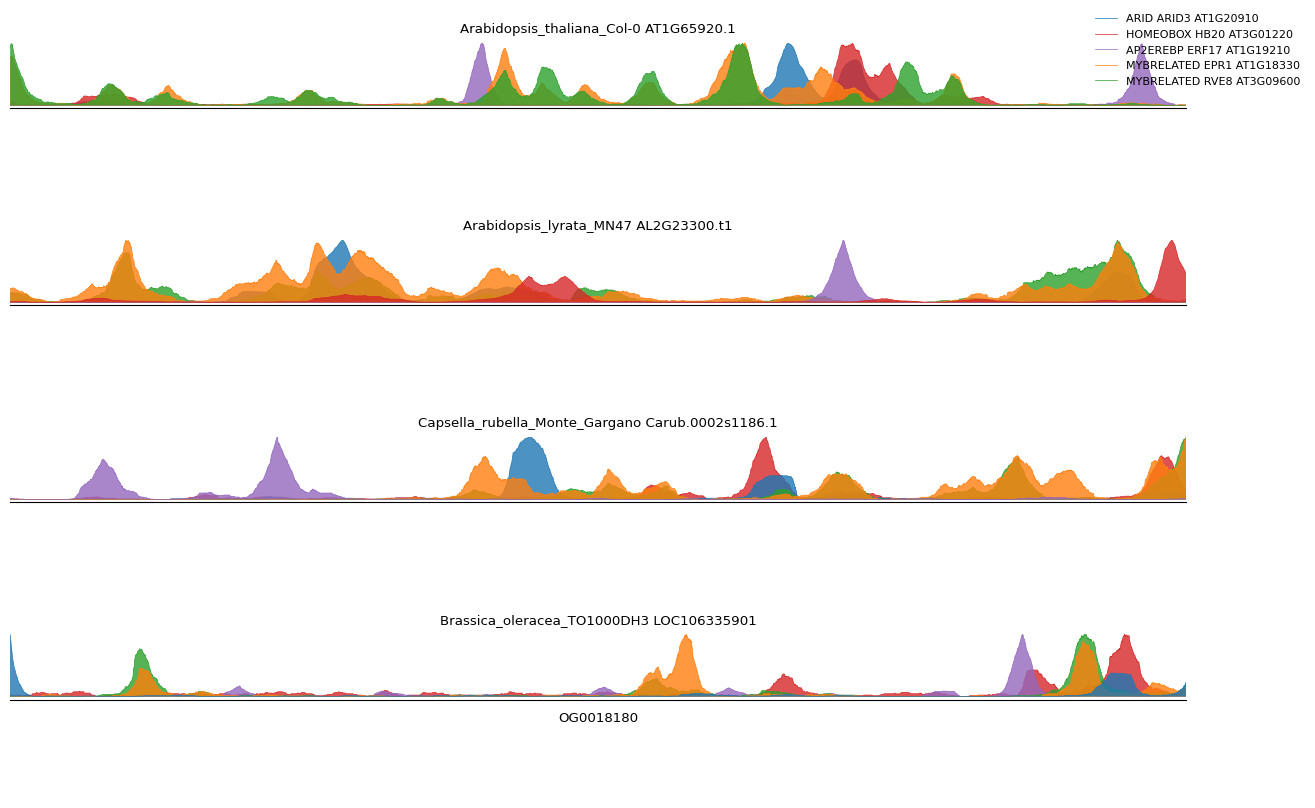

9
AT3G23050 AT3G23050.1 AT3G23050.1
Chr3
AT3G23050 AT3G23050.1 AT3G23050.1
Chr3
AT4G14550 AT4G14550.2 AT4G14550.2
Chr4
AT4G14550 AT4G14550.2 AT4G14550.2
Chr4
AT3G23050 AT3G23050.1 AT3G23050.1
Chr3
AT3G23050 AT3G23050.1 AT3G23050.1
Chr3
AT4G14550 AT4G14550.2 AT4G14550.2
Chr4
AT3G23050 AT3G23050.1 AT3G23050.1
Chr3
AL7G41590 AL7G41590.t1 AL7G41590.t1
scaffold_7
AL7G41590 AL7G41590.t1 AL7G41590.t1
scaffold_7
AL7G41590 AL7G41590.t1 AL7G41590.t1
scaffold_7
AL3G37490 AL3G37490.t1 AL3G37490.t1
scaffold_3
AL3G37490 AL3G37490.t1 AL3G37490.t1
scaffold_3
AL7G41590 AL7G41590.t1 AL7G41590.t1
scaffold_7
Carub.0007s2766 Carub.0007s2766.1 Carub.0007s2766.1
scaffold_7
Carub.0003s2321 Carub.0003s2321.1 Carub.0003s2321.1
scaffold_3
Carub.0007s2766 Carub.0007s2766.1 Carub.0007s2766.1
scaffold_7
Carub.0003s2321 Carub.0003s2321.1 Carub.0003s2321.1
scaffold_3
Carub.0003s2321 Carub.0003s2321.1 Carub.0003s2321.1
scaffold_3
Carub.0007s2766 Carub.0007s2766.1 Carub.0007s2766.1
scaffold_7
Carub.0007s2766 Carub.0007

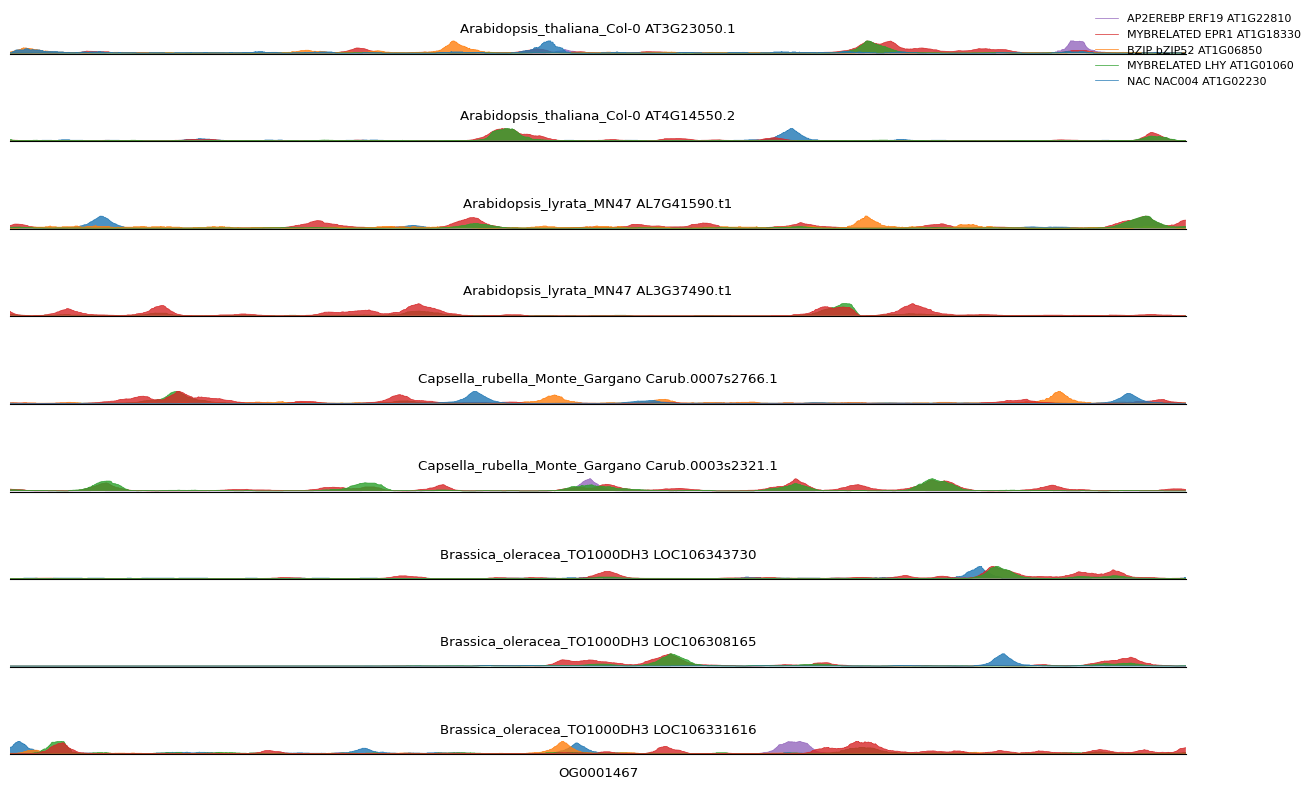

4
AT3G28857 AT3G28857.1 AT3G28857.1
Chr3
AT3G28857 AT3G28857.1 AT3G28857.1
Chr3
AT3G28857 AT3G28857.1 AT3G28857.1
Chr3
AT3G28857 AT3G28857.1 AT3G28857.1
Chr3
AT3G28857 AT3G28857.1 AT3G28857.1
Chr3
AL5G18620 AL5G18620.t1 AL5G18620.t1
scaffold_5
AL5G18620 AL5G18620.t1 AL5G18620.t1
scaffold_5
AL5G18620 AL5G18620.t1 AL5G18620.t1
scaffold_5
AL5G18620 AL5G18620.t1 AL5G18620.t1
scaffold_5
AL5G18620 AL5G18620.t1 AL5G18620.t1
scaffold_5
Carub.0005s0740 Carub.0005s0740.1 Carub.0005s0740.1
scaffold_5
Carub.0005s0740 Carub.0005s0740.1 Carub.0005s0740.1
scaffold_5
Carub.0005s0740 Carub.0005s0740.1 Carub.0005s0740.1
scaffold_5
Carub.0005s0740 Carub.0005s0740.1 Carub.0005s0740.1
scaffold_5
Carub.0005s0740 Carub.0005s0740.1 Carub.0005s0740.1
scaffold_5
LOC106316050 LOC106316050 XP_013609367.1
NC_027756.1
LOC106316050 LOC106316050 XP_013609367.1
NC_027756.1
LOC106316050 LOC106316050 XP_013609367.1
NC_027756.1
LOC106316050 LOC106316050 XP_013609367.1
NC_027756.1
LOC106316050 LOC106316050 XP_013609367.1


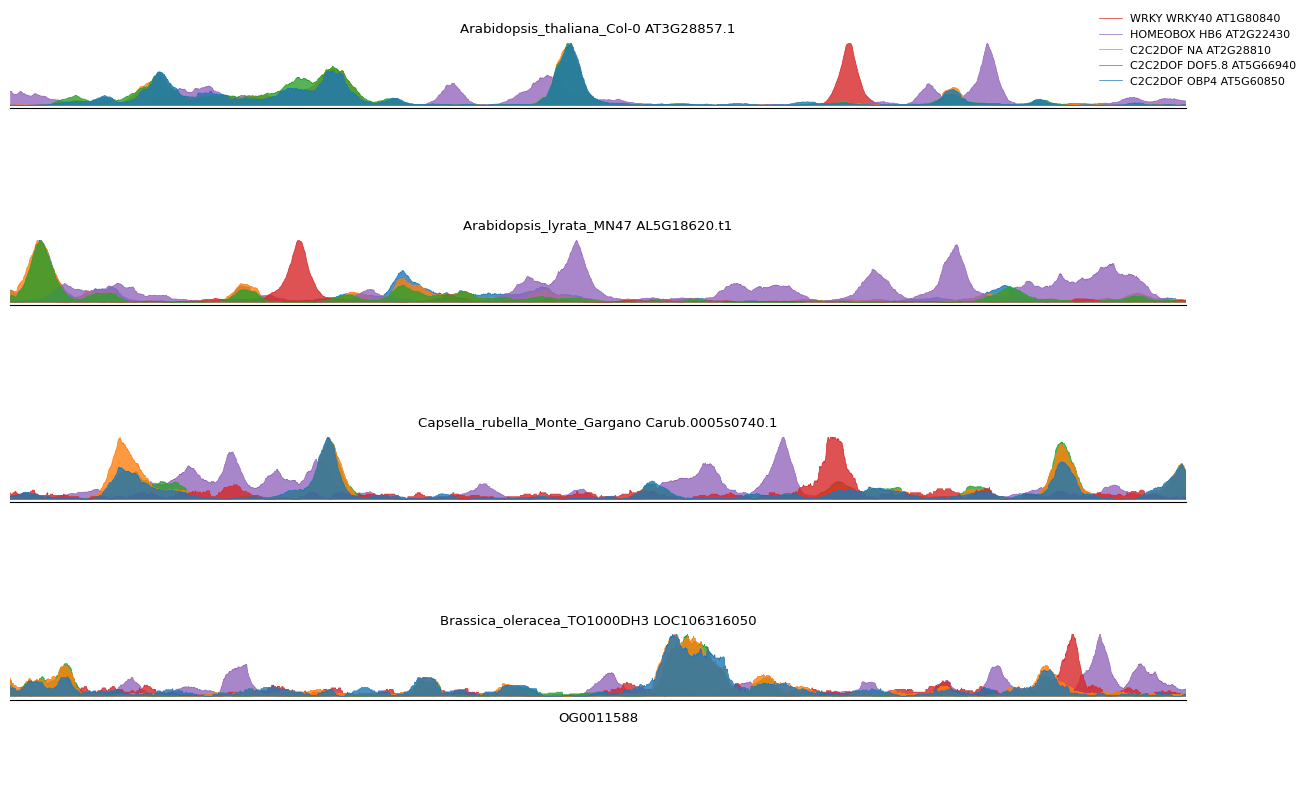

6
AT4G31320 AT4G31320.1 AT4G31320.1
Chr4
AT4G31320 AT4G31320.1 AT4G31320.1
Chr4
AT4G31320 AT4G31320.1 AT4G31320.1
Chr4
AT4G31320 AT4G31320.1 AT4G31320.1
Chr4
AT4G31320 AT4G31320.1 AT4G31320.1
Chr4
AT4G31320 AT4G31320.1 AT4G31320.1
Chr4
AL7G20760 AL7G20760.t1 AL7G20760.t1
scaffold_7
AL7G20760 AL7G20760.t1 AL7G20760.t1
scaffold_7
AL7G20760 AL7G20760.t1 AL7G20760.t1
scaffold_7
AL7G20760 AL7G20760.t1 AL7G20760.t1
scaffold_7
AL7G20760 AL7G20760.t1 AL7G20760.t1
scaffold_7
AL7G20760 AL7G20760.t1 AL7G20760.t1
scaffold_7
Carub.0007s0924 Carub.0007s0924.1 Carub.0007s0924.1
scaffold_7
Carub.0007s0924 Carub.0007s0924.1 Carub.0007s0924.1
scaffold_7
Carub.0007s0924 Carub.0007s0924.1 Carub.0007s0924.1
scaffold_7
Carub.0007s0924 Carub.0007s0924.1 Carub.0007s0924.1
scaffold_7
Carub.0007s0924 Carub.0007s0924.1 Carub.0007s0924.1
scaffold_7
Carub.0007s0924 Carub.0007s0924.1 Carub.0007s0924.1
scaffold_7
LOC106298786 LOC106298786 XP_013590380.1
NC_027748.1
LOC106334383 LOC106334383 XP_013628126.1
NC_027750.

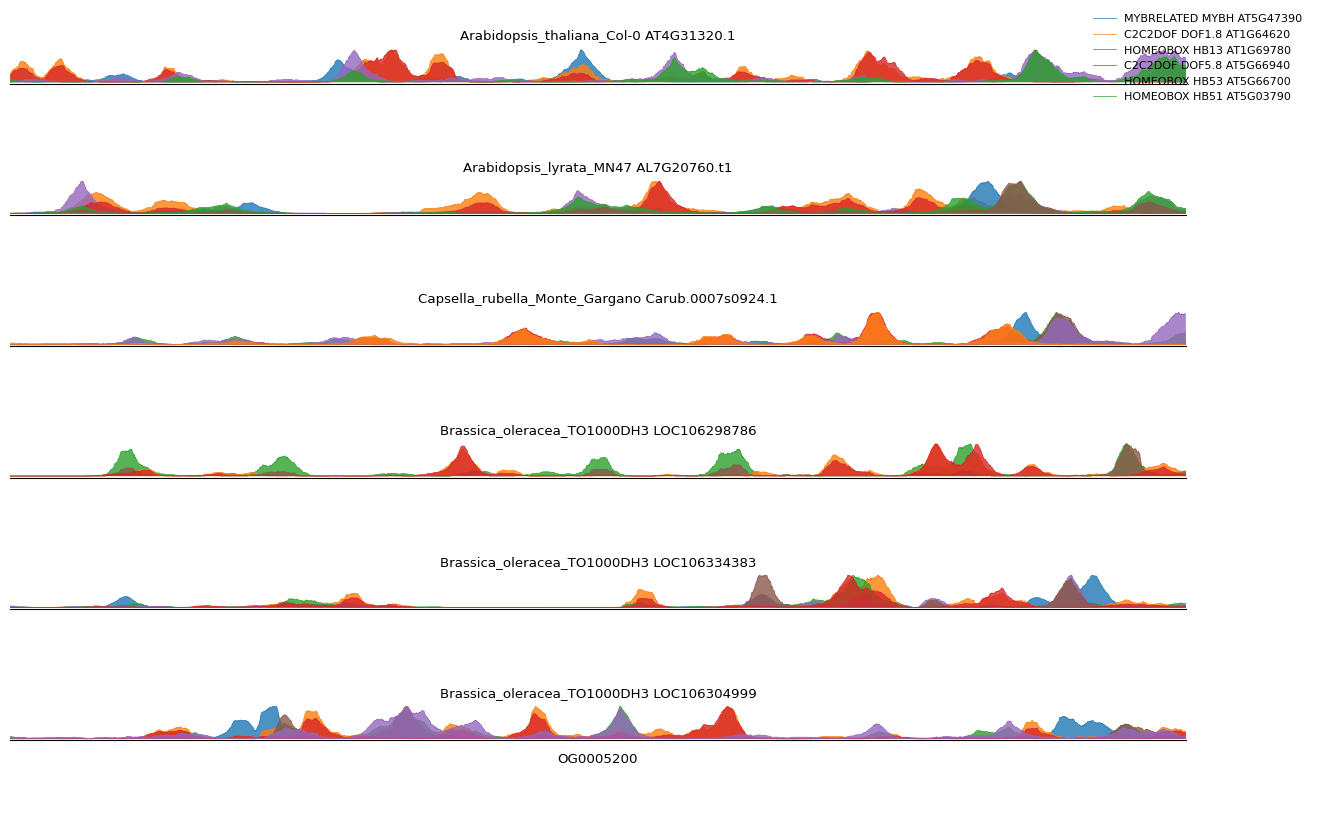

5
AT1G19840 AT1G19840.1 AT1G19840.1
Chr1
AT1G19840 AT1G19840.1 AT1G19840.1
Chr1
AT1G19840 AT1G19840.1 AT1G19840.1
Chr1
AT1G19840 AT1G19840.1 AT1G19840.1
Chr1
AT1G19840 AT1G19840.1 AT1G19840.1
Chr1
AT1G19840 AT1G19840.1 AT1G19840.1
Chr1
AL1G32560 AL1G32560.t1 AL1G32560.t1
scaffold_1
AL1G32560 AL1G32560.t1 AL1G32560.t1
scaffold_1
AL1G32560 AL1G32560.t1 AL1G32560.t1
scaffold_1
AL1G32560 AL1G32560.t1 AL1G32560.t1
scaffold_1
AL1G32560 AL1G32560.t1 AL1G32560.t1
scaffold_1
AL1G32560 AL1G32560.t1 AL1G32560.t1
scaffold_1
Carub.0001s1936 Carub.0001s1936.1 Carub.0001s1936.1
scaffold_1
Carub.0001s1936 Carub.0001s1936.1 Carub.0001s1936.1
scaffold_1
Carub.0001s1936 Carub.0001s1936.1 Carub.0001s1936.1
scaffold_1
Carub.0001s1936 Carub.0001s1936.1 Carub.0001s1936.1
scaffold_1
Carub.0001s1936 Carub.0001s1936.1 Carub.0001s1936.1
scaffold_1
Carub.0001s1936 Carub.0001s1936.1 Carub.0001s1936.1
scaffold_1
LOC106343130 LOC106343130 XP_013637721.1
NC_027752.1
LOC106343130 LOC106343130 XP_013637721.1
NC_027752.

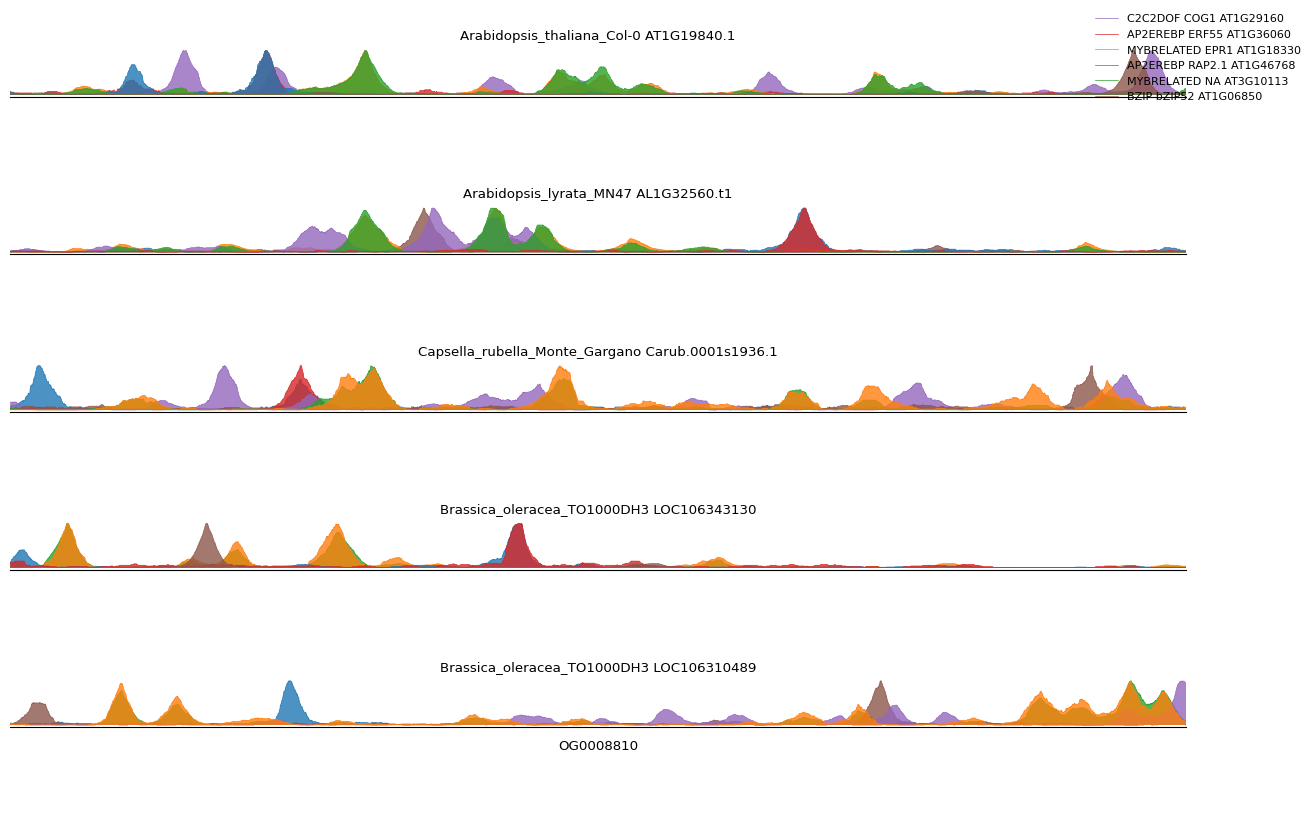

In [17]:
import matplotlib as mpl
from matplotlib import rcParams
# Set font properties globally
rcParams['pdf.fonttype'] = 42  # Ensures text is stored as editable text in PDF
rcParams['svg.fonttype'] = 'none'  # Ensures text is stored as editable text in SVG
#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Arial']  # Use a font that is available on your system
plt.rcParams.update({'font.size': 8})


plt.rcParams.update({'font.size': 8})


def extract_bw_vals(bw_path, chrom, start, end):
    # print(bw_path)
    # print(chrom)
    # print(start)
    # print(end)
    bw = pbw.open(bw_path)
    bw_vals = bw.values(chrom, int(start), int(end))
    return bw_vals

def library_name_to_bw_path(library_name):
    data_path = '/clusterfs/jgi/groups/gentech/seqtech/plant_multidap_data/multiN4_new/*'
    bigwig_path = glob(os.path.join(data_path, library_name+'_dedup_norm.bw'))
    return bigwig_path[0]


for selection in selections_to_plot:
    
    orthogroup_to_plot = selection['orthogroup']
    tfs_to_plot = selection['tfs']

    selected_peaks = filtered_annotated_peaks.copy()
    selected_peaks = selected_peaks[selected_peaks['tf'].isin(tfs_to_plot)]
    selected_peaks = selected_peaks[selected_peaks['orthogroup'] == orthogroup_to_plot]

    selected_peaks = selected_peaks.sort_values(by='peak_foldch').drop_duplicates(subset=['tf', 'species', 'target_id'], keep='last')
    selected_peaks['library_name'] = selected_peaks['peak_name'].str.split('_peak_').str[0]

    selected_peaks = pd.merge(left=selected_peaks, right=library_allowlist, on='library_name', how='left')


    #Color by tf
    unique_tfs = selected_peaks['tf'].unique()
    palette = sns.color_palette("tab10", len(unique_tfs))
    color_mapping = {tf: color for tf, color in zip(unique_tfs, palette)}

    plot_counter = 0

    # color_order = [0,1,2,3,4]
    # pal = sns.color_palette('YlGnBu', len(color_order)+1)
    # color_order = [1,2,3,4]
    # pal = sns.color_palette('deep', len(color_order))
    #color_order = [4,3,2,1]
    #pal = ['#01273E','#700160','#FF3E31','#FBCE1D','#FFF180']

    for group_name, group in selected_peaks.groupby('orthogroup'):

        plot_suffix = group_name

        group = group.sort_values(by='species_x', key=lambda s: [species_order.index(x) for x in s.values])

        n_gene_targets = group['target_id'].nunique()
        target_id_plot_order = group.drop_duplicates(subset='target_id')['target_id'].to_list()
        print(n_gene_targets)
        #fig, axes = plt.subplots(nrows=n_gene_targets*2, ncols=1, figsize=(3,6))
        fig, axes = plt.subplots(nrows=n_gene_targets*2, ncols=1, figsize=(12, 8))

        ax_nums_where_genes_already_plotted = []
        
        for idx, row in group.iterrows():

            species = row['species_x']
            target_id = row['target_id']
            target_protein_id = row['protein_id']
            target_gene = row['gene']

            print(f'{target_gene} {target_id} {target_protein_id}')
            tf = row['tf']
            strand = row['feature_strand']
            chrom = row['feature_chr']

            print(chrom)
            cons_score = row['cscore']

            tf_family = row['athaliana_tf_family']
            tf_name = row['athaliana_tf_name']
            if pd.isna(tf_name):
                tf_name = 'NA'
            tf_label =  f'{tf_family} {tf_name} {tf}'

            library_name = row['library_name']

            if strand == '+':
                plotting_start = row['feature_start'] + row['relative_cds_start'] - 10000
                plotting_end = row['feature_start'] + row['relative_cds_start'] - 2000
                cds_end = row['feature_end'] + row['relative_cds_end']
                cds_start = row['feature_start'] + row['relative_cds_start']
            else:
                plotting_end = row['feature_end'] - row['relative_cds_start'] + 10000
                plotting_start = row['feature_end'] - row['relative_cds_start'] + 2000
                cds_end = row['feature_start'] - row['relative_cds_end']
                cds_start = row['feature_end'] - row['relative_cds_start']

            bw_path = library_name_to_bw_path(library_name)

            bw_vals = extract_bw_vals(bw_path, chrom, plotting_start, plotting_end)

            coverage_ax_num = target_id_plot_order.index(target_id)*2
            ax = axes[coverage_ax_num]

            autoscale_factor = max(bw_vals)
            y_vals = [y/autoscale_factor for y in bw_vals]
            x_vals = [x for x in range(plotting_start, plotting_end, 1)]

            #color = pal[color_order.index(cons_score)]
            color = color_mapping[tf]

            sns.lineplot(ax=ax, x=x_vals, y=y_vals, color=color, label=tf_label, legend=False, linewidth=0.5, alpha=1, zorder=cons_score)
            ax.fill_between(x=x_vals, y1=y_vals, y2=0, facecolor=color, zorder=cons_score, alpha=0.8)#, edgecolor=color, hatch=hatches_string)

            #if coverage_ax_num == 0:
            ax.axvline(cds_end, color='gray', linestyle='--', zorder=0)
            ax.axvline(cds_start, color='gray', linestyle='--', zorder=0)
                #if strand == '+':
                #    ax.axvline(cds_start+500, color='black', linestyle='--', zorder=0, alpha=0.3)
                #else:
                #    ax.axvline(cds_start-500, color='black', linestyle='--', zorder=0, alpha=0.3)

            ax.set_xlim(plotting_start, plotting_end)
            if strand == '-':
                ax.invert_xaxis()       

            ax.set_title(f'{species} {target_id}')

            gene_cartoon_ax_num = target_id_plot_order.index(target_id)*2+1
            gene_cartoon_ax = axes[gene_cartoon_ax_num]               

            if gene_cartoon_ax_num not in ax_nums_where_genes_already_plotted:

                genes_to_draw = gff_by_species[species]
                genes_to_draw = genes_to_draw[genes_to_draw['feature_chrom'] == chrom]
                genes_to_draw = genes_to_draw[genes_to_draw['feature_strand'] == strand]
                genes_to_draw = genes_to_draw[genes_to_draw['gene_name'] == target_gene]
                genes_to_draw = genes_to_draw[genes_to_draw['feature_end'] >= plotting_start]
                genes_to_draw = genes_to_draw[genes_to_draw['feature_start'] >= plotting_start]
                

                for idx, gene_row in genes_to_draw.iterrows():
                    gene_start = gene_row['feature_start']
                    gene_end = gene_row['feature_end']
                    gene_strand = gene_row['feature_strand']
                    # gene_name = gene_row['gene_name']

                    # Ensure the gene representation fits within the plotting range
                    rect_start = max(gene_start, plotting_start)
                    rect_end = min(gene_end, plotting_end)
                    rect_width = rect_end - rect_start

                    # Choose a color or pattern based on the gene strand
                    if strand == '+':
                        if gene_strand == '+':
                            rect_color = 'black'  # Example color for positive strand
                        else:
                            rect_color = 'gray'   # Example color for negative strand
                    else:
                        if gene_strand == '+':
                            rect_color = 'gray'  # Example color for positive strand
                        else:
                            rect_color = 'black'   # Example color for negative strand


                    # Draw the rectangle for the gene
                    rect_patch = patches.Rectangle(
                        (rect_start, 0.8),  # Lower-left corner (x, y)
                        rect_width,         # Width
                        0.2,                # Height
                        edgecolor='black',
                        facecolor=rect_color,
                        linewidth=0,
                        zorder=10
                    )
                    gene_cartoon_ax.add_patch(rect_patch)

                gene_cartoon_ax.set_xlim(plotting_start, plotting_end)
                gene_cartoon_ax.spines['bottom'].set_visible(False)

               # plot_bed_box(plt_box, chrom, plotting_start, plotting_end, gene_strand, species, axis=gene_cartoon_ax, cds_start=cds_start)

                ax_nums_where_genes_already_plotted.append(gene_cartoon_ax_num)

                if strand == '-':
                    gene_cartoon_ax.invert_xaxis()
                

        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

        handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
        handles, labels = [sum(x, []) for x in zip(*handles_labels)]
        by_label = OrderedDict(zip(labels, handles))
        fig.legend(by_label.values(), by_label.keys(), loc='center', bbox_to_anchor=(1, 0.95), frameon=False)
        # plt.tight_layout()
        plt.tight_layout()
        #plt.savefig(f'DAPpeaks-{plot_suffix}.svg', bbox_inches='tight')
        #plt.savefig(f'DAPpeaks-{plot_suffix}.svg')
        plt.margins(x=2, y=0)
        plt.title(plot_suffix)
        plt.tight_layout()
        plt.savefig(f'DAPpeaks-{plot_suffix}.pdf',bbox_inches='tight')
        plt.show()